In [35]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import cv2
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")

# Load Data

In [36]:
seed = 42

In [37]:
from sklearn.model_selection import train_test_split
import pandas as pd

In [38]:
label_dict = {
    # Controls
    'n': 0,
    # Chirrhosis
    'cirrhosis': 1,
    # Colorectal Cancer
    'cancer': 1, 'small_adenoma': 0,
    # IBD
    'ibd_ulcerative_colitis': 1, 'ibd_crohn_disease': 1,
    # T2D and WT2D
    't2d': 1,
    # Obesity
    'leaness': 0, 'obesity': 1,
}
def loadData(data_dir, filename, dtype=None):
    feature_string = ''
    if filename.split('_')[0] == 'abundance':
        feature_string = "k__"
    if filename.split('_')[0] == 'marker':
        feature_string = "gi|"
    # read file
    filename = data_dir + filename
    if not os.path.isfile(filename):
        print("FileNotFoundError: File {} does not exist".format(filename))
        exit()
    raw = pd.read_csv(filename, sep='\t', index_col=0, header=None)

    # select rows having feature index identifier string
    X = raw.loc[raw.index.str.contains(feature_string, regex=False)].T

    # get class labels
    Y = raw.loc['disease']
    Y = Y.replace(label_dict)

    # train and test split
    X_train, X_test, y_train, y_test = train_test_split(X.values.astype(dtype), Y.values.astype('int'), test_size=0.2, random_state=seed, stratify=Y.values)
    print("Train data shape: ", X_train.shape)
    print("Test data shape: ", X_test.shape)
    return X_train, X_test, y_train, y_test

data_dir = '../data/abundance/'
data_string = 'abundance_Cirrhosis.txt'
X_train, X_test, y_train, y_test = loadData(data_dir, data_string, dtype='float32')

Train data shape:  (185, 542)
Test data shape:  (47, 542)


In [39]:
import math
onesideDim = int(math.sqrt(X_train.shape[1])) + 1
enlargedDim = onesideDim ** 2
X_train = np.column_stack((X_train, np.zeros((X_train.shape[0], enlargedDim - X_train.shape[1]))))
X_test = np.column_stack((X_test, np.zeros((X_test.shape[0], enlargedDim - X_test.shape[1]))))

# reshape
X_train = np.reshape(X_train, (len(X_train), onesideDim, onesideDim, 1))
X_test = np.reshape(X_test, (len(X_test), onesideDim, onesideDim, 1))
# to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test), torch.tensor(y_test)), batch_size=32, shuffle=False)

In [40]:
print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (185, 24, 24, 1)
Test data shape:  (47, 24, 24, 1)


# Define the CAE model

In [41]:
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        # CNN as encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 6)
        )

        # CNN as decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 6),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    @staticmethod
    def loss_func(x_hat, x):
        return F.binary_cross_entropy(x_hat, x, reduction='sum')

In [42]:
model = CAE().to(device)

# Model training and evaluation

In [43]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)

losses = []
for epoch in range(50):

    """ model training """
    model.train()
    cur_rec_loss = []
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        data = data.transpose(1, 3)
        rec = model(data)
        loss = model.loss_func(rec, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_rec_loss.append(loss.item())
    losses.append(np.mean(cur_rec_loss))

    """ model evaluation """
    with torch.no_grad():
        test_loss = []
        for batch_idx, (data, _) in enumerate(testloader):
            data = data.to(device)
            data = data.transpose(1, 3)
            rec = model(data)
            loss = model.loss_func(rec, data)
            test_loss.append(loss.item())

    if epoch % 10 == 0:
        print (f"-- epoch {epoch} --, train MSE: {np.mean(cur_rec_loss)}, test MSE: {np.mean(test_loss)}")

-- epoch 0 --, train MSE: 10720.88916015625, test MSE: 7839.89453125
-- epoch 10 --, train MSE: -130208.1328125, test MSE: -101666.8828125
-- epoch 20 --, train MSE: -138048.99479166666, test MSE: -103154.8125
-- epoch 30 --, train MSE: -139782.44661458334, test MSE: -105296.27734375
-- epoch 40 --, train MSE: -148564.47395833334, test MSE: -108234.671875


# Draw Loss and Accuracy Curves

Text(0.5, 1.0, 'rec MSE loss')

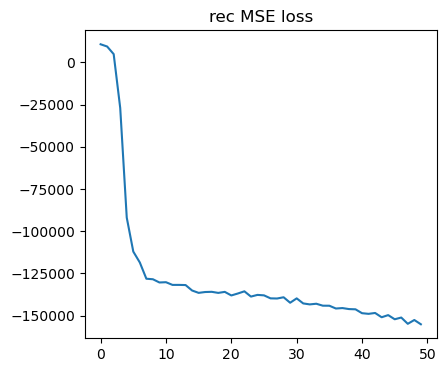

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(losses)
plt.title("rec MSE loss")

# Transform the data by using the trained model

In [45]:
X_train = torch.tensor(X_train).to(device)
X_test = torch.tensor(X_test).to(device)

X_train = X_train.transpose(1, 3)
X_test = X_test.transpose(1, 3)
X_train_encoded = model.encoder(X_train).cpu().detach().numpy()
X_test_encoded = model.encoder(X_test).cpu().detach().numpy()

In [46]:
print("Encoded train data shape: ", X_train_encoded.shape)
print("Encoded test data shape: ", X_test_encoded.shape)

Encoded train data shape:  (185, 64, 1, 1)
Encoded test data shape:  (47, 64, 1, 1)


In [47]:
X_train_encoded = np.reshape(X_train_encoded, (X_train_encoded.shape[0], -1))
X_test_encoded = np.reshape(X_test_encoded, (X_test_encoded.shape[0], -1))

# Classification by using the transformed data

In [48]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
def get_metrics(clf, is_svm=False):
    y_true, y_pred = y_test, clf.predict(X_test_encoded)
    y_prob = 0
    if is_svm:
        y_prob = clf.decision_function(X_test_encoded)
    else:
        y_prob = clf.predict_proba(X_test_encoded)
    # Performance Metrics: AUC, ACC, Recall, Precision, F1_score
    metrics = {
    'ACC': accuracy_score(y_true, y_pred),
    'Recall': recall_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred),
    'F1_score': f1_score(y_true, y_pred),
    }
    if not is_svm:
        metrics['AUC'] = roc_auc_score(y_true, y_prob[:, 1])
    else:
        metrics['AUC'] = roc_auc_score(y_true, y_prob)
    return metrics

In [49]:
# SVM
from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf, is_svm=True))

{'ACC': 0.6808510638297872, 'Recall': 0.625, 'Precision': 0.7142857142857143, 'F1_score': 0.6666666666666666, 'AUC': 0.7590579710144927}


In [50]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf))

{'ACC': 0.7021276595744681, 'Recall': 0.5833333333333334, 'Precision': 0.7777777777777778, 'F1_score': 0.6666666666666666, 'AUC': 0.7681159420289855}


In [51]:
# Multi-layer Perceptron
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=1000)
clf.fit(X_train_encoded, y_train)
print(get_metrics(clf))

{'ACC': 0.574468085106383, 'Recall': 0.5833333333333334, 'Precision': 0.5833333333333334, 'F1_score': 0.5833333333333334, 'AUC': 0.6340579710144927}
